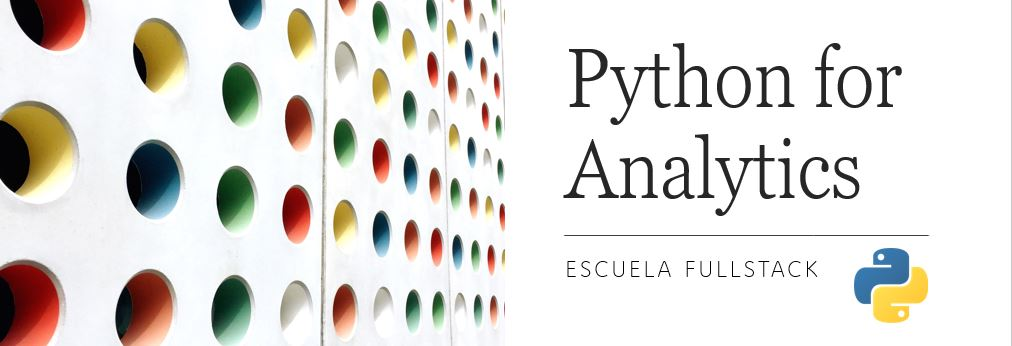

## **Caso aplicativo: NETFLIX**

Iniciaremos la exploración de nuestro dataset, cómo están organizados los datos y la estructura, para a continuación preparar los diferentes DataFrames que nos serán de utilidad en nuestro análisis descriptivo.

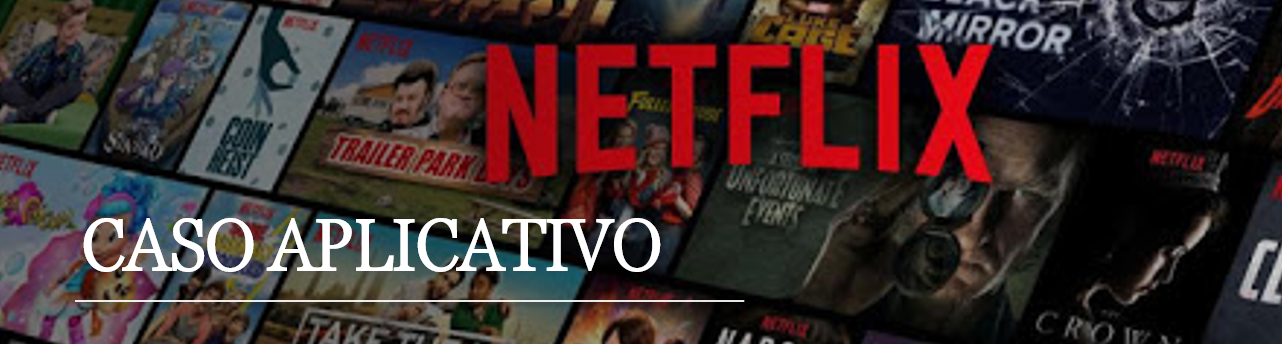

Para nuestro caso aplicativo usaremos datos disponibles en la web de Kaggle.

https://www.kaggle.com/shivamb/netflix-shows

### **Procesamiento de Datos**

In [ ]:
#Importamos las librerías que podríamos utilizar

import pandas as pd
import numpy as np

In [ ]:
#Leyendo los datos del caso aplicativo
from google.colab import files
cargar = files.upload()

df = pd.read_csv("/content/netflix_titles.csv",sep=",")
df.head()

In [ ]:
#Datos del Dataframe: lista de columnas

df.columns

In [ ]:
#Datos del Dataframe: dimensiones

df.shape

In [ ]:
#Datos del Dataframe: detalles de datos vacíos

df.isna().sum()

In [ ]:
#Excluiremos las líneas con valores nulos de fecha y llenaremos los datos vacíos de director, cast, country y rating

df["director"] = df["director"].fillna("No definido")
df["cast"] = df["cast"].fillna("No definido")
df["country"] = df["country"].fillna("No definido")
df["rating"] = df["rating"].fillna("No definido")

df = df.dropna()

In [ ]:
#Datos del Dataframe: tipo de datos por columna

df.dtypes

In [ ]:
#Accediendo a los datos únicos del dataset

df.nunique()

In [ ]:
# Realizando cambio de nombre de columnas

df1 = df.copy()
df1 = df1.rename(columns={"show_id":"ID Show"
                          ,"type":"Tipo"
                          ,"title":"Titulo"
                          ,"director":"Director"
                          ,"cast":"Actores"
                          ,"country":"Pais"
                          ,"date_added":"Fecha agregado"
                          ,"release_year":"Anho publicado"
                          ,"rating":"Tipo publico"
                          ,"duration":"Duracion"
                          ,"listed_in":"Genero"
                          ,"description":"Descripcion"
                          })

df1.head()

In [ ]:
#Cambiando a formato de fecha

df1["Fecha agregado"] = pd.to_datetime(df1["Fecha agregado"])
df1["Dia agregado"] = df1["Fecha agregado"].dt.day
df1["Anho agregado"] = df1["Fecha agregado"].dt.year
df1["Mes agregado"] = df1["Fecha agregado"].dt.month
df1["Anho agregado"].astype(int)
df1["Dia agregado"].astype(int)
df1["Mes agregado"].astype(int)

df1.head()

In [ ]:
#Evaluando cuáles son los valores únicos de la columna Tipo

df1["Tipo"].unique()

In [ ]:
#Evaluando cuáles son los valores únicos de la columna Género

df1["Tipo publico"].unique()

También podemos combinar este dataset con otros disponibles en la web, como lo son los ratings del público.

Para esto usaremos 2 datasets con data del sitio web IMDb.
https://www.imdb.com/

Estos datasets están disponibles en el siguiente link:
https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset

In [ ]:
#Leyendo los datos complementarios del caso aplicativo
from google.colab import files
cargar = files.upload()

ratings = pd.read_csv("/content/IMDb ratings.csv",sep=",",usecols=["weighted_average_vote"])
ratings.head()

In [ ]:
#Leyendo los datos complementarios del caso aplicativo
from google.colab import files
cargar = files.upload()

titulos = pd.read_csv("/content/IMDb movies.csv",sep=",",usecols=["title","year","genre"])
titulos.head()

In [ ]:
#Consolidando ambos datasets en uno

ratings2 = pd.DataFrame({"Titulo":titulos.title,
                    "Anho lanzamiento":titulos.year,
                    "Rating": ratings.weighted_average_vote,
                    "Genero":titulos.genre})

ratings2.head()

In [ ]:
#Eliminando duplicados previo a la unión de ambas tablas

ratings2 = ratings2.drop_duplicates(subset=["Titulo","Anho lanzamiento","Rating"])
ratings2.head()

In [ ]:
#Eliminando datos vacíos

ratings2 = ratings2.dropna()

In [ ]:
#Agrupar ambas tablas: Netflix y ratings de películas

df2 = df1.merge(ratings2,on="Titulo",how="inner",suffixes = ["_Netflix","_IMDB"])
df2.head()

### **Análisis Descriptivo Exploratorio de Datos**

In [ ]:
#Importamos las librerías de visualización

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
#Recordemos la estructura de nuestro dataset

df2.head()

In [ ]:
#Podemos comenzar por evaluar el número de programas publicados por año

df3 = df2.groupby(["Anho agregado"])["ID Show"].count().reset_index()

plt.plot(df3["Anho agregado"], df3["ID Show"])
plt.title("Programas agregados a Netflix por año")
plt.xlabel("Año")
plt.ylabel("Número de programas")
plt.show()

Observamos que en el año 2020, la tendencia cae versus el año 2019 y venía en crecimiento, entonces vamos a evaluar a qué se debe.

In [ ]:
#Revisamos cuáles son las fechas más recientes de programas agregados

df2["Fecha agregado"].sort_values(ascending = False).value_counts()

Entonces debido a que la última fecha fue el 1 de enero del 2020, debemos considerar este hecho en nuestro análisis.

In [ ]:
#Vamos a evaluar ahora cómo se fueron agregando los programas por tipo

df3 = df2.groupby(["Anho agregado","Tipo"])["ID Show"].count().reset_index()

sns.barplot(x="Anho agregado",y="ID Show",hue="Tipo",data=df3)
plt.title("Programas agregados a Netflix por año por tipo")
plt.xlabel("Año")
plt.ylabel("Número de programas")
plt.show()

Observamos que las películas (Movie) son los principales programas que ofrece Netflix en mucha mayor medida vs. las series, aunque ambas continúan creciendo en número.

In [ ]:
#Incluyamos también un nuevo tipo de visualización: Nube de Palabras (Word Cloud) para visualizar 

#Para esto usaremos la librería WordCloud
from wordcloud import WordCloud

plt.subplots(figsize=(15,10))
wordcloud = WordCloud(background_color='white',width=1920,height=1080).generate(" ".join(df2["Pais"]))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('paises.png')
plt.show()

Observamos que Estados Unidos es el país con más contenido ya que la frase "United States" es la más grande en la nube, seguido por Reino Unido e India.

In [ ]:
#Veamos ahora la medida de Duración

df2["Duracion"].unique()

Vemos que tiene diferentes valores divididos en 2 tipos: minutos y temporadas (seasons). Entonces vamos a crear una columna adicional para separarlos.

In [ ]:
#Creamos una nueva columna de Duración numérica

df2["Duracion_num"] = df2["Duracion"].replace([" min"," Seasons"," Season"],"",regex=True).astype(int)

df2.head(2)

In [ ]:
#Ahora evaluaremos por separado la duración de películas y series debido a su naturaleza

#Visualizamos primero la distribución de duración de películas
df3 = df2[df2["Tipo"]=="Movie"]

sns.distplot(df3["Duracion_num"])
plt.title("Duración de películas")
plt.show()

In [ ]:
#Complementamos con la visualización de sus estadísticos

df3["Duracion_num"].describe()

Observamos que la duración media es de 103min, pero tiene una distribución generalmente inclinada hacia la izquierda, es decir que pocas películas van mucho más allá de 2 horas en general.

In [ ]:
#Ahora veamos la distribución de duración de series en número de temporadas
df3 = df2[df2["Tipo"]=="TV Show"]

sns.distplot(df3["Duracion_num"])
plt.title("Duración de series")
plt.show()

In [ ]:
#Complementamos con la visualización de sus estadísticos

df3["Duracion_num"].describe()

En el caso de las series, la gran mayoría tiene solo una temporada, mientras que pocas tienen 2 o 3 y en aún menos casos más allá, siendo la seria con mayor número de temporadas una que tiene 14. Veamos qué serie es.

In [ ]:
#Revisamos qué serie cuenta con 14 temporadas

df2.loc[(df2["Duracion_num"]==14) & (df2["Tipo"]=="TV Show"),"Titulo"]

In [ ]:
#Veamos también a qué categorías pertenece el contenido

df3 = df2.groupby(["Genero_Netflix"])["ID Show"].count().reset_index()

#Los ordenamos de mayor a menor
df3 = df3.sort_values("ID Show",ascending=False)

sns.barplot(x="ID Show",y="Genero_Netflix",data=df3[0:20])
plt.xlabel("Nro de programas")
plt.show()

In [ ]:
#Veamos también a qué categorías pertenece el contenido

df3 = df2.groupby(["Genero_IMDB"])["ID Show"].count().reset_index()

#Los ordenamos de mayor a menor
df3 = df3.sort_values("ID Show",ascending=False)

sns.barplot(x="ID Show",y="Genero_IMDB",data=df3[0:20])
plt.xlabel("Nro de programas")
plt.show()

Vemos que en IMDB existe una categorización más estándar y los principales géneros son de Drama, Comedia y Romance y combinaciones de los mismos.

In [ ]:
#Ahora veamos la distribución de ratings en un box plot según tipo

sns.boxplot(x="Tipo", y="Rating", data=df2)
plt.show()

In [ ]:
#Ahora veamos la distribución de ratings en un box plot según tipo

sns.boxplot(x="Tipo", y="Rating", hue="Anho agregado", data=df2)
plt.legend(bbox_to_anchor=(-0.2, 1),loc="upper right")
plt.show()

### **Hipótesis y Análisis de Resultados**

Para resolver las preguntas de negocio debemos empezar entendiendo el contexto de la situación, luego entendemos la data y preparamos para luego proceder a realizar el análisis.

### Metodología CRISP-DM

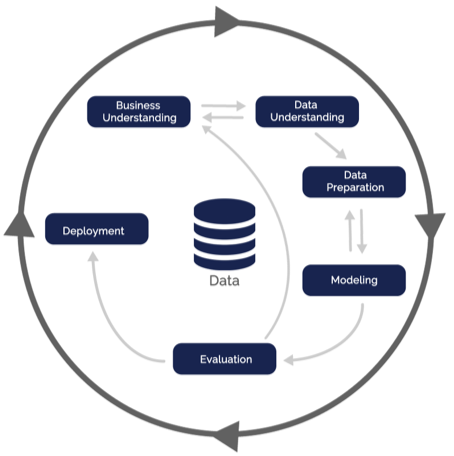

### Entonces, ¿qué preguntas podríamos querer resolver?

Veremos el caso de qué tipo de programas es el que más gustó al público para evaluar si se puede reaplicar en nuevos planes.

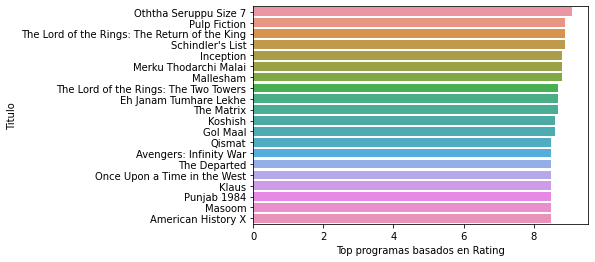

In [56]:
#Veamos qué programas tienen mayor rating

df3 = df2.groupby(["Titulo"])["Rating"].mean().reset_index()

#Los ordenamos de mayor a menor
df3 = df3.sort_values("Rating",ascending=False)

sns.barplot(x="Rating",y="Titulo",data=df3[0:20])
plt.xlabel("Top programas basados en Rating")
plt.show()

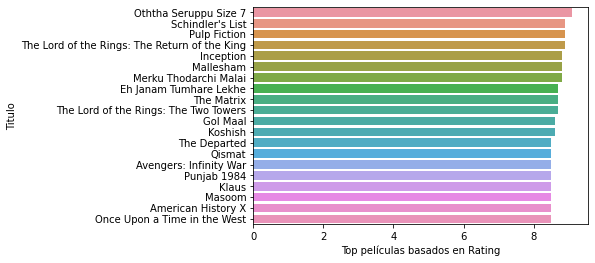

In [57]:
#Veamos qué películas tienen mayor rating

df3 = df2[df2["Tipo"]=="Movie"]
df3 = df3.groupby(["Titulo"])["Rating"].mean().reset_index()

#Los ordenamos de mayor a menor
df3 = df3.sort_values("Rating",ascending=False)

sns.barplot(x="Rating",y="Titulo",data=df3[0:20])
plt.xlabel("Top películas basados en Rating")
plt.show()

In [58]:
#Qué película tiene mayor rating

df2[df2["Titulo"] == "Oththa Seruppu Size 7"]

,ID Show,Tipo,Titulo,Director,Actores,Pais,Fecha agregado,Anho publicado,Tipo publico,Duracion,Genero_Netflix,Descripcion,Dia agregado,Anho agregado,Mes agregado,Anho lanzamiento,Rating,Genero_IMDB,Duracion_num
540,81206389,Movie,Oththa Seruppu Size 7,Parthiban,Parthiban,India,2019-11-04,2019,TV-MA,103 min,"Dramas, International Movies, Thrillers","Taken into custody, a murder suspect's theatri...",4,2019,11,2019,9.1,Drama,103


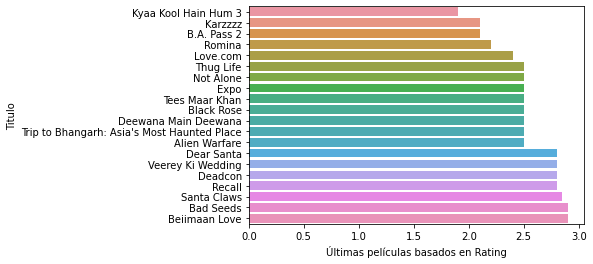

In [59]:
#Veamos qué películas tienen mayor rating

df3 = df2[df2["Tipo"]=="Movie"]
df3 = df3.groupby(["Titulo"])["Rating"].mean().reset_index()

#Los ordenamos de mayor a menor
df3 = df3.sort_values("Rating",ascending=True)

sns.barplot(x="Rating",y="Titulo",data=df3[0:20])
plt.xlabel("Últimas películas basados en Rating")
plt.show()

In [60]:
#Qué película tiene menor rating

df2[df2["Titulo"] == "Kyaa Kool Hain Hum 3"]

,ID Show,Tipo,Titulo,Director,Actores,Pais,Fecha agregado,Anho publicado,Tipo publico,Duracion,Genero_Netflix,Descripcion,Dia agregado,Anho agregado,Mes agregado,Anho lanzamiento,Rating,Genero_IMDB,Duracion_num
939,80108481,Movie,Kyaa Kool Hain Hum 3,Umesh Ghadge,"Tusshar Kapoor, Aftab Shivdasani, Krishna Abhi...",India,2019-05-15,2016,R,124 min,"Comedies, International Movies",When an unlikely porn actor falls for a woman ...,15,2019,5,2016,1.9,Comedy,124


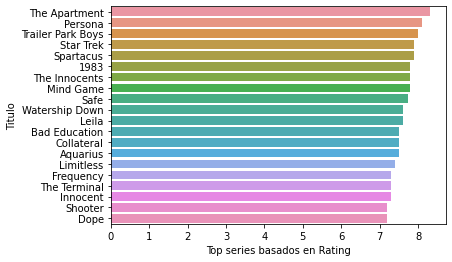

In [61]:
#Veamos qué series tienen mayor rating

df3 = df2[df2["Tipo"]=="TV Show"]
df3 = df3.groupby(["Titulo"])["Rating"].mean().reset_index()

#Los ordenamos de mayor a menor
df3 = df3.sort_values("Rating",ascending=False)

sns.barplot(x="Rating",y="Titulo",data=df3[0:20])
plt.xlabel("Top series basados en Rating")
plt.show()

In [62]:
#Qué serie tiene mayor rating

df2[df2["Titulo"] == "The Apartment"]

,ID Show,Tipo,Titulo,Director,Actores,Pais,Fecha agregado,Anho publicado,Tipo publico,Duracion,Genero_Netflix,Descripcion,Dia agregado,Anho agregado,Mes agregado,Anho lanzamiento,Rating,Genero_IMDB,Duracion_num
3014,80989867,TV Show,The Apartment,No definido,"Jamie Durie, Laurence Llewelyn-Bowen",Singapore,2018-12-14,2014,TV-PG,2 Seasons,"International TV Shows, Reality TV","With their eyes on the grand prize, amateur de...",14,2018,12,1960,8.3,"Comedy, Drama, Romance",2


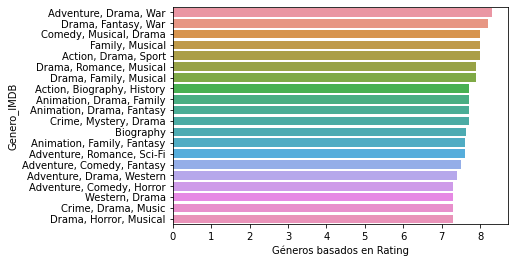

In [63]:
#Veamos qué géneros tienen mayor rating

df3 = df2.groupby(["Genero_IMDB"])["Rating"].mean().reset_index()

#Los ordenamos de mayor a menor
df3 = df3.sort_values("Rating",ascending=False)

sns.barplot(x="Rating",y="Genero_IMDB",data=df3[0:20])
plt.xlabel("Géneros basados en Rating")
plt.show()

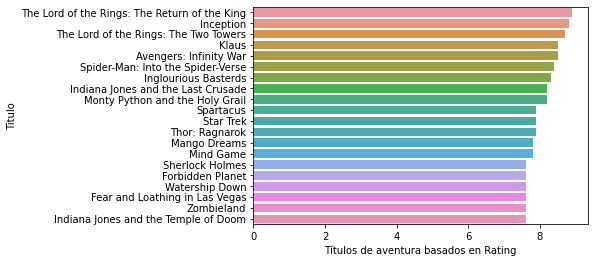

In [64]:
#Veamos qué géneros tienen mayor rating

df3 = df2[df2["Genero_IMDB"].str.contains("Adventure")]
df3 = df3.groupby(["Titulo"])["Rating"].mean().reset_index()

#Los ordenamos de mayor a menor
df3 = df3.sort_values("Rating",ascending=False)

sns.barplot(x="Rating",y="Titulo",data=df3[0:20])
plt.xlabel("Títulos de aventura basados en Rating")
plt.show()

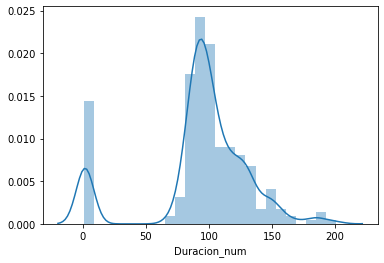

In [65]:
#Duración de películas de Aventura

df3 = df2[df2["Genero_IMDB"].str.contains("Adventure")]
sns.distplot(df3["Duracion_num"])
plt.show()

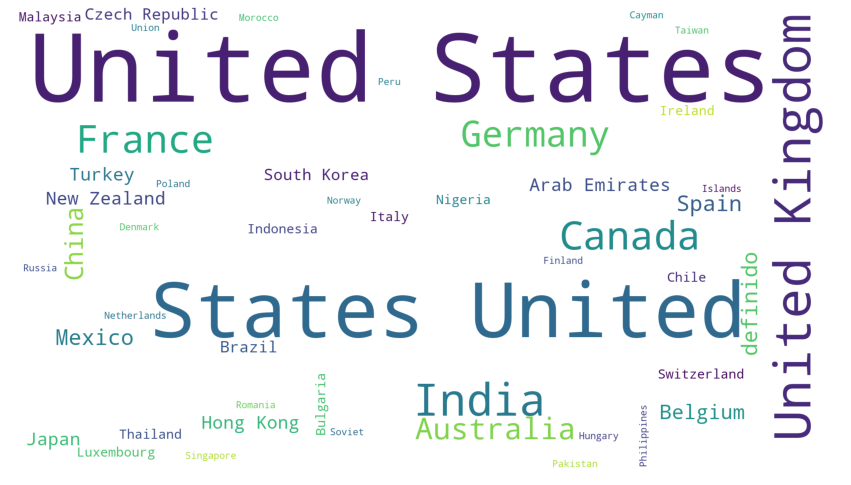

In [66]:
#Veamos en qué países se realizaron estos programas

plt.subplots(figsize=(15,10))
wordcloud = WordCloud(background_color='white',width=1920,height=1080).generate(" ".join(df3["Pais"]))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('paises2.png')
plt.show()